In [1]:
using DrWatson

@quickactivate "Hadjivasiliou_Julia_Tutorial"

projectname()

"Hadjivasiliou_Julia_Tutorial"

In [2]:
using DifferentialEquations
using ModelingToolkit
using Symbolics
using BenchmarkTools
using Plots

First basic ODE:

$\frac{du}{dt} = f(u,p,t)$

where $f(u,p,t) = pu$, on the time interval $t\in[0,5]$ with the initial condition $u_0 = 0.5$

We will initially use The Euler method. The Euler method is an example of an explicit method. This means that the new value $u_{n+1}$ is defined in terms of things that are already known, e.g. $u_n$.  

For this simple example, the Euler method would yield the following update:

$\frac{u(t+h) - u(t)}{h} = pu(t) \implies u(t+h) = u(t) + hpu(t)$ 

or, $u_{n+1} = u_{n} + hpu_n$

In [3]:
u0 = 0.5
tspan = (0.0,5.0)
p = -0.5

n_time_steps = 1000

h = (tspan[2] - tspan[1])/(n_time_steps-1)

u = zeros(n_time_steps)

u[1] = u0

for n in 1:n_time_steps-1
    u[n+1] = u[n] + h*p*u[n]
end

In [4]:
plot(tspan[1]:h:tspan[2],u,linewidth=5,title="Solution to the linear ODE", xaxis="Time (t)",yaxis="u(t)",label="Homemade Euler")
plot!(tspan[1]:h:tspan[2],map(t->u0*exp(p*t),tspan[1]:h:tspan[2]),label="True solution",c = :red)

savefig(plotsdir("Simple_exp_2Solutions.png"))

In [5]:
function f(u,p,t)
    p*u
end

u0 = 0.5
tspan = (0.0,5.0)
p = -0.5

prob = ODEProblem(f,u0,tspan,p)
sol = solve(prob, Euler(), dt = h);

In [6]:
plot(sol,title="Solution to the linear ODE",xaxis="Time (t)",yaxis="u(t)",label="DiffEq Euler()",c = :green) # legend=false

plot!(tspan[1]:h:tspan[2],u,title="Solution to the linear ODE", xaxis="Time (t)",yaxis="u(t)",label="Homemade Euler", c= :blue)
plot!(tspan[1]:h:tspan[2],map(t->u0*exp(p*t),tspan[1]:h:tspan[2]),label="True solution",c = :red)

savefig(plotsdir("Simple_exp_3Solutions.png"))

In [7]:
sol.retcode

ReturnCode.Success = 1

In [8]:
sol.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  1000
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          999
Number of rejected steps:                          0

https://en.wikipedia.org/wiki/Euler_method#Global_truncation_error

The system we solved has an analytic solution $u(t) = u_0 \exp(pt)$. We can therefore calculate the global truncation error for a range of h. 

The GTE $e_n$ at time $t_n$ is defined by $e_n = u(t_n) - u_n$ where $u(t_n)$ is the true solution $u_n$ is the corresponding estimate produced by the numerical procedure: 

In [9]:
result = Dict{Float64,Float64}()

for h in [0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
    sol = solve(prob, Euler(), dt = h);
    GTE = maximum(map(t->u0*exp(p*t) - sol(t),sol.t))
    result[h] = GTE
end

In [10]:
scatter(result,xaxis = :log,  yaxis = "max e_n",xlabel = "h",title = "Maximum GTE versus step size",label = false)

savefig(plotsdir("Euler_Max_GTE.png"))

Interestingly, the error varies across the solution. 

In some way it is dependent on the system it is solving and where you are with your current estimate. This is the idea behind adaptive methods.

In [11]:
sol_1 = solve(prob, Euler(), dt = 0.1);
sol_2 = solve(prob, Euler(), dt = 0.01);

plot(sol_1.t, t->abs(u0*exp(p*t) - sol_1(t)),lw=3,ls=:dash,label="h = " * string(0.1),xaxis="Time (t)", yaxis = "Error e(t)", title = "Euler GTE versus time")

plot!(sol_2.t, t->abs(u0*exp(p*t) - sol_2(t)),lw=3,ls=:dash,label="h = " * string(0.01))

savefig(plotsdir("Euler_GTE_Versus_time.png"))

An example of an adaptive method is Runga-Kutta Tsit5(). It varies the step size dending on its own estimate of solution error. 

Lets control for the same error seen by Euler. This is done using reltol and abstol. 

According to the DifferntialEquation documentation, a good rule of thumb is that the total solution accuracy is 1-2 digits less than the relative tolerance reltol. Lets set reltol = 1e-6, abstol = 1e-6 and see.

In [12]:
sol_tsit5 = solve(prob, Tsit5(), reltol=1e-6, abstol=1e-6)

sol_tsit5.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  93
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          15
Number of rejected steps:                          0

In [13]:
sol_euler = solve(prob, Euler(), dt = 0.000001)
sol_euler.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  5000001
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          5000000
Number of rejected steps:                          0

In [14]:
plot(sol_tsit5.t, t->abs(u0*exp(p*t) - sol_tsit5(t)),lw=3,ls=:dash,xaxis="Time (t)", yaxis = "Error e(t)", label = "Tsit5", title = "Comparison of GTE versus time")
plot!(sol_tsit5.t, t->abs(u0*exp(p*t) - sol_euler(t)),lw=3,ls=:dash,xaxis="Time (t)", yaxis = "Error e(t)", label = "Euler")


savefig(plotsdir("Tsit5_GTE_Versus_time.png"))

In [15]:
@benchmark solve(prob, Euler(), dt = 0.000001, save_everystep = false)

BenchmarkTools.Trial: 20 samples with 1 evaluation.
 Range (min … max):  256.692 ms … 275.470 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     261.711 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   263.320 ms ±   5.157 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁     █ ▁ █▁▁  ▁█▁▁▁           █  ▁        ▁             ▁  ▁  
  █▁▁▁▁▁█▁█▁███▁▁█████▁▁▁▁▁▁▁▁▁▁▁█▁▁█▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁█ ▁
  257 ms           Histogram: frequency by time          275 ms <

 Memory estimate: 1.88 KiB, allocs estimate: 22.

In [16]:
@benchmark solve(prob, Tsit5(), reltol=1e-6, abstol=1e-6,save_everystep = false)

BenchmarkTools.Trial: 10000 samples with 9 evaluations.
 Range (min … max):  2.481 μs …  12.940 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     2.801 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.840 μs ± 353.146 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

          ▁▃▃▂▆█▅▂▂▃▁                                          
  ▂▃▃▃▄▆█▇███████████▇▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂ ▃
  2.48 μs         Histogram: frequency by time        3.86 μs <

 Memory estimate: 3.28 KiB, allocs estimate: 22.

Next ODE: morphogen gradient - diffusion and linear degradation term

$\frac{\partial c}{\partial t} = D \frac{\partial ^ 2 c}{\partial x ^2}  - kc$

with source term $D\frac{\partial c}{\partial x}|_{x=0} = -j_0$ and zero flux at the end of the tissue, $D\frac{\partial c}{\partial x}|_{x=L} = 0$

The analytic solution $c(x) = c_0\exp(-x/\lambda) + c_1\exp(x/\lambda)$, where $\lambda = \sqrt{\frac{D}{k}}$

Lets solve this using the "method of lines". This involves transforming the PDE into a system of ODE's by discretizing in space. 

Suppose we discretize $[0,L]$ into $N$ cells, giving a step of $\Delta x = \frac{L}{N-1}$.

Then we let $ c_j(t) = c(x_j,t)$ where $x_j = j\Delta x$ for $j = 1,\cdots, N$. 

Given this definition, we can write 

$\frac{\partial}{\partial x} c(x,t) |_{x = x_j} = \frac{c_{i+1}(t) - c_{i-1}(t)}{2*\Delta x}$ and

$\frac{\partial^2}{\partial x ^ 2} c(x,t) |_{x = x_j} = \frac{\frac{c_{j+1}(t) - c_{j}(t)}{\Delta x} - \frac{c_{j}(t) - c_{j-1}(t)}{\Delta x}}{\Delta x} = \frac{c_{j+1}(t) + c_{j-1}(t) - 2*c_{j}(t)}{\Delta x ^ 2}$

Since

$\frac{\partial}{\partial t} c(x,t) |_{x = x_j} = D\frac{\partial^2}{\partial x ^ 2} c(x,t) |_{x = x_j} - kc(x,t)|_{x=x_j}$

we get the system of ODEs

$\frac{d}{dt}c_j(t) = D\frac{c_{j+1}(t) + c_{j-1}(t) - 2*c_{j}(t)}{\Delta x ^ 2} - k c_j(t)$

The Neumann boundary conditions are handled as follows:

$D\frac{\partial}{\partial x} c(x,t) |_{x = 0} = -j_0 \implies \frac{c_{1}(t) - c_{0}(t)}{2*\Delta x} = -j_0/D$ 

and

$D\frac{\partial}{\partial x} c(x,t) |_{x = L} = 0 \implies \frac{c_{N+1}(t) - c_{N}(t)}{2*\Delta x} = 0$ 

which give us correct substitions for $\frac{d}{dt}c_0(t)$ and $\frac{d}{dt}c_N(t)$

Since this gives us a system of ODEs, we can use any of the ODE timestepping methods to solve our system and hence the PDE.

In [17]:
const Nc = 1000
const L = 1.

const tissue = range(0,L,length = Nc)


function morph_grad!(du,u,p,t)

    D,k,j0,dx = p

    h = 1/dx^2

    du[1] = (2*u[2] + (2*dx*j0/D) - 2*u[1]) / dx^2 - k*u[1]

    @inbounds for j in 2:Nc-1
        du[j] =  D*h*(u[j-1] + u[j+1] - 2*u[j]) - k*u[j]
    end

    du[Nc] = (2*u[Nc-1] - 2*u[Nc]) / dx^2 - k*u[Nc]
    
end

morph_grad! (generic function with 1 method)

In [18]:
# https://sites.me.ucsb.edu/~moehlis/APC591/tutorials/tutorial5/node3.html#diffusion_eqn_fd
# https://folk.ntnu.no/leifh/teaching/tkt4140/._main056.html

In [19]:
D = 0.16
k = 1.
j0 = 0.4

p = (D,k,j0,step(tissue))

u0 = zeros(Nc)

tspan = (0,Inf)

prob = ODEProblem(morph_grad!,u0,tspan,p)

# sol = solve(prob, AutoTsit5(Rosenbrock23()),abstol = 1e-8,reltol = 1e-6,callback = TerminateSteadyState(1e-8,1e-6),maxiters = 1e6)
sol = solve(prob, AutoTsit5(Rosenbrock23()),abstol = 1e-8,reltol = 1e-6,callback = TerminateSteadyState(1e-8,1e-6),maxiters = 1e6)

retcode: Terminated
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 464-element Vector{Float64}:
  0.0
  3.375071079470019e-7
  4.906068215506494e-7
  7.685488240587792e-7
  1.0028008673752744e-6
  1.3057321208301405e-6
  1.615627540396592e-6
  1.981040008928833e-6
  2.3830318855361687e-6
  2.8509255142019124e-6
  ⋮
  9.064984364271563
  9.435932902002195
  9.851241158284413
 10.322159688059974
 10.864631098175895
 11.502204960076897
 12.271684421761838
 13.234510278273993
 14.504178944925679
u: 464-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0012337512816123376, 3.549977304301032e-5, 6.587448677940347e-7, 9.100027314720017e-9, 9.601136251918147e-11, 1.0977284826885444e-12, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0015814678161879866, 6.7643593905526e-5, 1.8475816718028873e-6, 3.723

In [20]:
sol_adaptive = solve(prob, AutoTsit5(Rosenbrock23()),abstol = 1e-8,reltol = 1e-6,callback = TerminateSteadyState(1e-8,1e-6),maxiters = 1e6)
sol_euler = solve(prob, Euler(),dt = 0.00001,callback = TerminateSteadyState(1e-8,1e-6),maxiters = 1e9);

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523


In [21]:
print("Number of steps to reach steady state, Adaptive method: " *string(length(sol_adaptive.t)) * "\n")
print("Number of steps to reach steady state, Euler method: " *string(length(sol_euler.t)))

Number of steps to reach steady state, Adaptive method: 464
Number of steps to reach steady state, Euler method: 42

In [22]:
plot(sol_adaptive.t[2:end] .-  sol_adaptive.t[1:end-1], yaxis = :log10, ylabel = "h,step size",xlabel = "Iteration", label = "AutoTsit5(Rosenbrock23())", legend = :topleft)

hline!([0.00001],yaxis = :log10, label = "Euler")

savefig(plotsdir("AdaptiveSteppingSS.png"))

In [23]:
histogram(sol_adaptive.t, xlabel = "Time", ylabel = "Frequency of time stepping", label = "AutoTsit5(Rosenbrock23())")

savefig(plotsdir("AdaptiveSteppingSSHistogram.png"))

In [24]:
@benchmark solve(prob, AutoTsit5(Rosenbrock23()),abstol = 1e-8,reltol = 1e-6,callback = TerminateSteadyState(1e-8,1e-6),maxiters = 1e6)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 36.733 s (0.00% GC) to evaluate,
 with a memory estimate of 42.31 MiB, over 3992 allocations.

In [25]:
@benchmark solve(prob, Euler(),dt = 0.000001,callback = TerminateSteadyState(1e-8,1e-6),maxiters = 1e9)

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523


┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

Excessive output truncated after 524377 bytes.

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  124.667 μs … 18.285 ms  ┊ GC (min … max):  0.00% … 98.23%
 Time  (median):     188.042 μs              ┊ GC (median):     0.00%
 Time  (mean ± σ):   256.864 μs ±  1.017 ms  ┊ GC (mean ± σ):  25.51% ±  6.36%

                ▁██▇▅▂                                          
  ▂▃▃▃▂▂▂▂▂▂▃▅▅▆███████▆▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂ ▃
  125 μs          Histogram: frequency by time          348 μs <

 Memory estimate: 1.02 MiB, allocs estimate: 237.

In [26]:
sol = solve(prob, AutoTsit5(Rosenbrock23()),abstol = 1e-8,reltol = 1e-6,callback = TerminateSteadyState(1e-8,1e-6),maxiters = 1e6);

https://scicomp.stackexchange.com/questions/25398/understanding-the-courant-friedrichs-lewy-condition

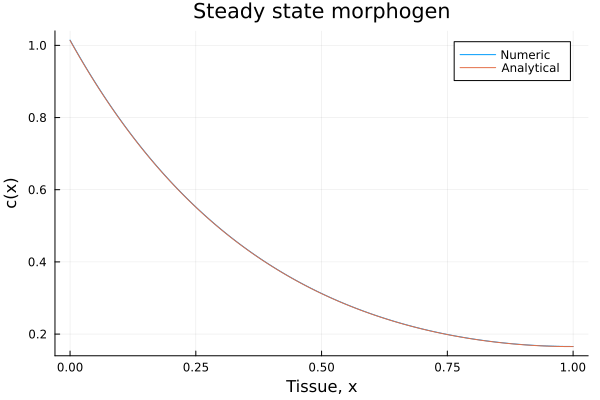

In [27]:
λ = sqrt(D/k)
c0 = (j0*λ/D)*(1/(1-exp(-2*L/λ)))
c1 = (j0*λ/D)*(exp(-2*L/λ)/(1-exp(-2*L/λ)));

plot(tissue,sol.u[end],label = "Numeric",title = "Steady state morphogen",xaxis = "Tissue, x",yaxis = "c(x)")
plot!(tissue,x->c0*exp(-x/λ) + c1*exp(x/λ),label= "Analytical")


# savefig(plotsdir("SteadystateMorph.png"))

In [28]:
# plot(tissue,map(x->c0*exp(-x/λ) + c1*exp(x/λ),tissue) .- sol.u[end],label= false,xlabel = "tissue(x)", yaxis = "Error")

In [29]:
tspan = (0,round(sol.t[end]))

prob = ODEProblem(morph_grad!,u0,tspan,p);

sol = solve(prob, AutoTsit5(Rosenbrock23()),abstol = 1e-8,reltol = 1e-6,saveat = 0:0.001:8.0);

In [30]:
anim = @animate for i = 1:length(sol.u)
    plot(tissue,sol.u[i],xlabel = "Tissue, x",ylabel =  "c(x)",title = "t = " * string(sol.t[i]),label = "Morphogen")
    plot!(ylims = (0.,1.2))
end
 
gif(anim, plotsdir("Animations","MorphogenSteadyState.gif"), fps = 30)

In [ ]:
tspan = (0,Inf)

prob = ODEProblem(morph_grad!,u0,tspan,p);

In [ ]:
@benchmark solve(prob, AutoTsit5(Rosenbrock23()),abstol = 1e-8,reltol = 1e-6,callback = TerminateSteadyState(1e-8,1e-6),maxiters = 1e6)

In [ ]:
using Symbolics

In [ ]:
du0 = copy(u0) # what does dg look like
jac_sparsity = Symbolics.jacobian_sparsity((du,u)->morph_grad!(du,u,p,0.0),du0,u0)

In [ ]:
# https://github.com/SciML/DiffEqCallbacks.jl/blob/4cf478d21527327a52bf3c7916c29cd155115a51/src/terminatesteadystate.jl

In [ ]:
morph_grad_sparse = ODEFunction(morph_grad!;jac_prototype=float.(jac_sparsity));

prob_sparse  = ODEProblem(morph_grad_sparse,u0,tspan,p);

In [ ]:
@benchmark solve(prob_sparse, AutoTsit5(Rosenbrock23()),abstol = 1e-8,reltol = 1e-6,callback = TerminateSteadyState(1e-8,1e-6),maxiters = 1e6)

$\frac{du_i}{dt} = pu_i$ for $i = 1,\cdots N$

on the time interval $t\in[0,15]$ with the initial condition $u_1 = 0.2$

For any $(i,t)$ s.t. $u_i(t) = 1$, the system grows by one e.g. N = N + 1

In [ ]:
function f(du,u,p,t)
    for i in 1:length(u)
        du[i] = p.α*u[i]
    end

end

function condition(u,t,integrator)
    return 1.0 - maximum(u) # has any cell hit 1? 
end

function affect!(integrator)
    
    u = integrator.u
    
    idx = findall(y-> y >= 1.0, u) # find all cells which have hit concentration == 1
    
    resize!(integrator,length(u)+length(idx)) # resize solution to accomodate all new divisions

    for id in reverse(idx) # for each cell hitting 1, divide:
        u[id+2:end] .= @view u[id+1:end-1]
        u[id] *= 0.5
        u[id+1] = u[id]
    end
    
    nothing
end

callback = ContinuousCallback(condition,affect!, rootfind=SciMLBase.RightRootFind)
u0 = [0.2]
tspan = (0.0,15.0)
p = (; α = 0.3)
prob = ODEProblem(f,u0,tspan, p)
sol = solve(prob,Tsit5(),callback=callback,saveat = tspan[1]:0.1:tspan[2]);

In [ ]:
ts = range(0, stop=tspan[2], length=1000)
plot(ts,map((x)->x[1],sol.(ts)),lw=3, ylabel="Amount of u in Cell 1",xlabel="Time",label = false)

savefig(plotsdir("GrowingCellCOnc.png"))

In [ ]:
plot(sol.t,map(x->length(x),sol.u),yaxis = "Number of cells", xaxis = "Time",label = false)

savefig(plotsdir("GrowingCellNumber.png"))

In [ ]:
# https://diffeq.sciml.ai/stable/analysis/parameter_estimation/

In [ ]:
 function prob_func(prob,i,repeat)
    remake(prob,p=(rand(),)
end

  ensemble_prob = EnsembleProblem(ODEProblem(lotka_volterra,u0,tspan,θ),
                                  prob_func = prob_func)
  sol = solve(ensemble_prob,Tsit5(),EnsembleThreads(),trajectories=1000)
  
  using DiffEqBase.EnsembleAnalysis
  plot(EnsembleSummary(sol))